In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc

EVALUATION_FOLDER = "evaluation_minbzk"
RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_keywords_BM25S.csv"

woo_data = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE}")

In [18]:
def process_average(n=1):
    """
    Where n is the number of pages retrieved (max 50).
    """
    results_summary = []
    thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for threshold in thresholds:
        headers = ['dossier_id', 'retrieved_dossier_id', 'confidence', 'result', 'scores']
        df = pd.DataFrame(columns=headers)

        for index, row in woo_data.iterrows():
            dossier_ids = row["retrieved_dossier_ids"].split(", ")[:n]
            unique_dossier_ids_set = set(dossier_ids)
            unique_dossier_ids_dict = {key: 0 for key in unique_dossier_ids_set}
            # If only 1 dossier has been retrieved, set confidence to 1
            if len(unique_dossier_ids_dict) <= 1:
                # Set confidence to 1
                result = {key: 1 for key in unique_dossier_ids_dict}
            else:
                # Iterate over the dossier# columns
                for key in unique_dossier_ids_dict:
                    for index, dossier_id in enumerate(dossier_ids):
                        if key != dossier_id:
                            continue
                        unique_dossier_ids_dict[key] += 1
                result = {key: value / sum(unique_dossier_ids_dict.values()) for key, value in unique_dossier_ids_dict.items()}

            # print(result)
            max_key = max(result, key=result.get)
            df.loc[len(df)] = [
                row['dossier_id'],
                max_key,
                result[max_key],
                "N/A" if result[max_key] < threshold else row['dossier_id'] == max_key,
                str(result)
            ]

        true_count = df['result'].value_counts().get(True, 0)
        false_count = df['result'].value_counts().get(False, 0)
        na_count = df['result'].value_counts().get("N/A", 0)

        print(f"Threshold: {threshold}, True: {true_count}, False: {false_count}, N/A: {na_count}")
        results_summary.append({
            'Threshold': threshold,
            'True': true_count,
            'False': false_count,
            'N/A': na_count
        })
    return results_summary

def process_average_roc(n=1):
    results_summary = []
    threshold_size = 100
    thresholds = [i / (threshold_size - 1) for i in range(threshold_size)]

    for threshold in thresholds:
        first_result_true = []
        first_result_false = []

        for index, row in woo_data.iterrows():
            # Get MAP
            dossier_ids = row["retrieved_dossier_ids"].split(", ")
            unique_dossier_ids_set = set(dossier_ids)
            unique_dossier_ids_dict = {key: 0 for key in unique_dossier_ids_set}

            if len(unique_dossier_ids_dict) <= 1:
                result = {key: 1.0 for key in unique_dossier_ids_dict}
            else:
                for key in unique_dossier_ids_dict:
                    for idx, dossier_id in enumerate(dossier_ids):
                        if key != dossier_id:
                            continue
                        unique_dossier_ids_dict[key] += 1
                result = {key: value / sum(unique_dossier_ids_dict.values()) for key, value in unique_dossier_ids_dict.items()}

            # Iterate through dossier columns based on the provided `n`
            for i in range(1, n + 1):
                dossier_col_name = f'dossier#{i}'
                if dossier_col_name in row:
                    if row[dossier_col_name] == True:
                        first_result_true.append(result.get(dossier_ids[i-1], 0))
                    else:
                        first_result_false.append(result.get(dossier_ids[i-1], 0))

        tp_count = sum(1 for x in first_result_true if x >= threshold)
        fp_count = sum(1 for x in first_result_false if x >= threshold)
        fn_count = sum(1 for x in first_result_true if x < threshold)
        tn_count = sum(1 for x in first_result_false if x < threshold)
        results_summary.append({
            'Threshold': threshold,
            'tp': tp_count,
            'fp': fp_count,
            'fn': fn_count,
            'tn': tn_count
        })

    return results_summary

def create_roc_auc(results, n):
    # Calculate TPR and FPR
    tpr = [d['tp'] / (d['tp'] + d['fn']) for d in results]
    fpr = [(d['fp'] / (d['fp'] + d['tn']) if (d['fp'] + d['tn']) != 0 else 0) for d in results]

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='o')
    plt.title(f'ROC Curve Average for n = {n}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.grid(True)
    plt.show()

    print(f"The AUC for the ROC curve is: {auc(fpr, tpr):.8f}")

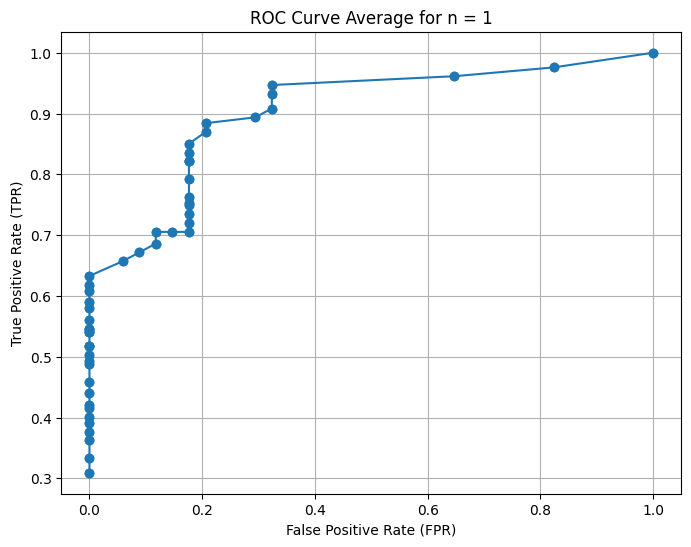

The AUC for the ROC curve is: 0.90309747


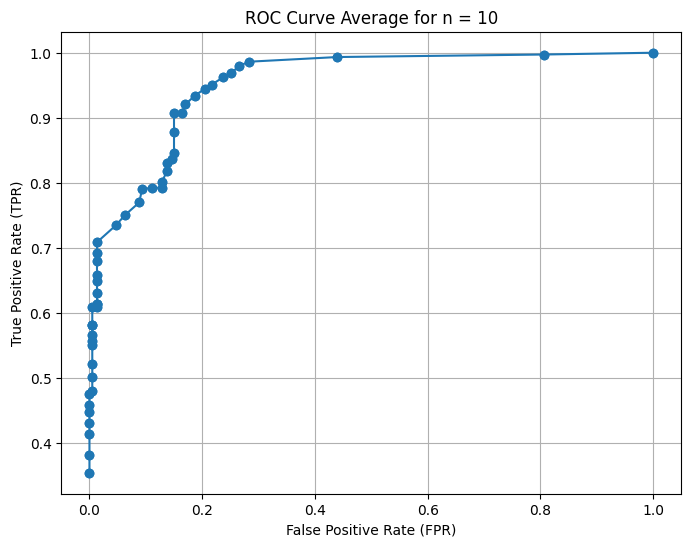

The AUC for the ROC curve is: 0.95191621


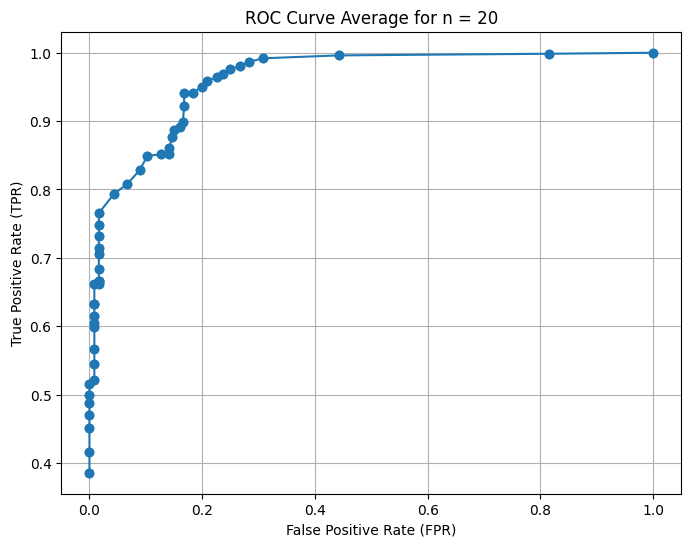

The AUC for the ROC curve is: 0.96106703


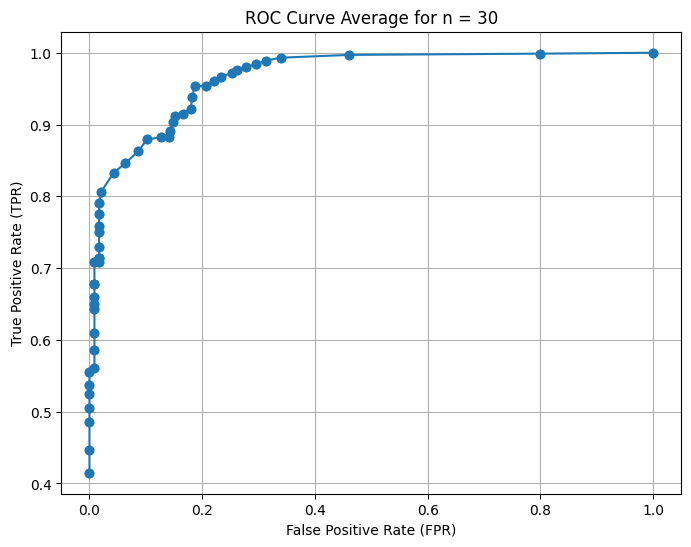

The AUC for the ROC curve is: 0.96638274


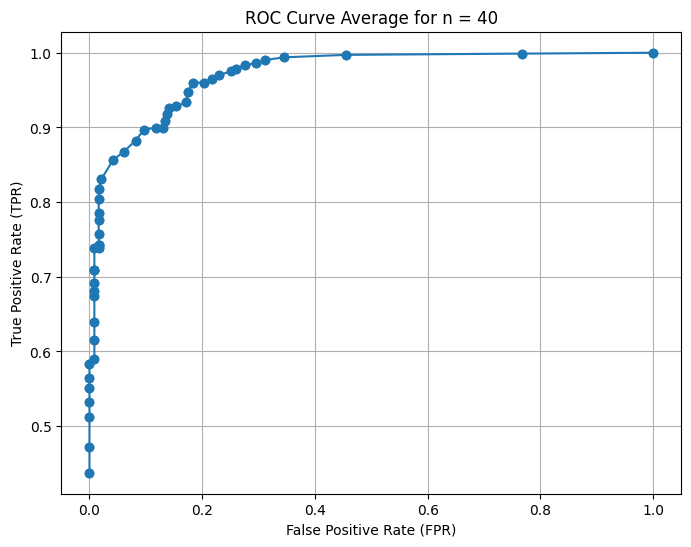

The AUC for the ROC curve is: 0.97147988


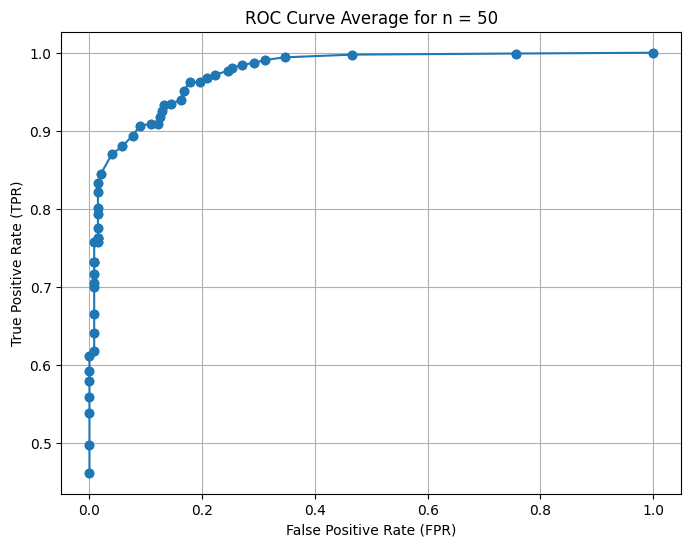

The AUC for the ROC curve is: 0.97488260


In [19]:
dossier_id_limits = [1, 10, 20, 30, 40, 50]
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Normal
for i in dossier_id_limits:
    results_df = pd.DataFrame(process_average(i))
    plt.figure(figsize=(12, 8))

    plt.plot(results_df['Threshold'], results_df['True'], marker='o', label='True')
    plt.plot(results_df['Threshold'], results_df['False'], marker='o', label='False')
    plt.plot(results_df['Threshold'], results_df['N/A'], marker='o', label='N/A')

    plt.title(f'Results Summary for Different Thresholds with nr of pages retrieved = {i}')
    plt.xlabel('Threshold')
    plt.ylabel('Values')
    plt.xticks(thresholds)
    plt.grid(True)
    plt.legend()
    plt.show()

# ROC
for i in dossier_id_limits:
    results = process_average_roc(i)
    create_roc_auc(results, i)
